In [ ]:
conda env export > environment.yml

In [1]:
import os
import re, string, unicodedata
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

In [2]:
import inflect
from spellchecker import SpellChecker
import csv

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.stanford import StanfordTokenizer

In [373]:
# import dataset
df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

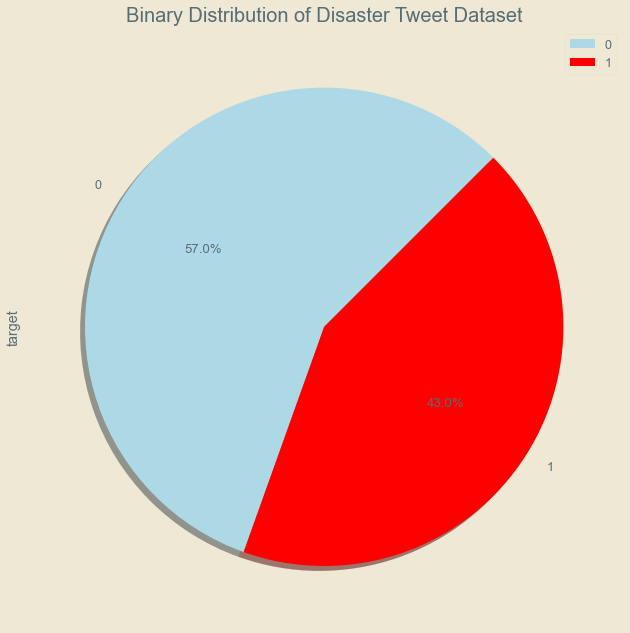

In [5]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

In [6]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}

In [7]:
location_expansion_dict = csv2dict('location_expansion.csv')
word_expansion_dict = csv2dict('word_expansions.csv')

In [356]:
def word_expansion_from_dict(text, expansion_dict):
    #function to replace words from precomposed dictionary 
        d_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
        def replace(match):
            expansion = f"{expansion_dict[match.group(0)]}"
            return expansion
        new_text = d_re.sub(replace, text)
        return new_text

def camel_case_split(text):
    if text.startswith('#'):
    #function to expand hashtags containing camel case to words using capital letters as markers for split
        text = re.sub('#', ' ', text)
        # regex to insert space before uppercase letter when not at start of line using pos.lookahead and pos.lookbehind
        exp_hashtags = re.sub(r'((?<!\A)(?<=[a-z])[A-Z]|(?<!\A)(?=[A-Z])[a-z+])', r' \1', text)
    else:
        exp_hashtags = text
    return exp_hashtags

    
def lemmatize_text(text, pos_tag):
    #function to tokenize and lemmatize text, removing twitter handles and reducing length of words ex. loool = lol
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w, pos=pos_tag) for w in tokenizer.tokenize(text)]
    return ' '.join(x for x in norm_text(tokens) if len(x) > 1)

def replace_numbers(tokens):
    # function to replace digits in string with numbers spelled out as words ex 11 = eleven
    dig2word = inflect.engine()
    new_tokens = []
    for word in tokens:
        word = re.sub('(?<=\d),(?=\d)', '', word)
        if word.isdigit():
            new_word = dig2word.number_to_words(int(word))
            new_tokens.append(str(new_word))
        else:
            new_tokens.append(word)
    return new_tokens

# def remove_non_ascii(tokens):
#     # function to remove non unicode characters
#     new_tokens = []
#     for word in tokens:
#         new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#         new_tokens.append(new_token)
#     return new_tokens

def remove_stopwords(tokens):
    # function to remove stopwords from text
    stop_list = stopwords.words('english')  
    new_tokens = []
    for word in tokens:
        if word not in stop_list:
            new_tokens.append(word)
    return new_tokens

def norm_text(tokens):
    # function to normalize text by replacing digits with words and removing stopwords performed on tokenized text
    words = replace_numbers(tokens)
    new_words = remove_stopwords(words)
    return new_words

    # function to remove urls, NaN string, non-unicode characters
def denoise_text(text):
    new_text = re.sub(r"\S*https?:\S*",  r"", text)
    newish_text = re.sub("@[^\s]+",  r" ", new_text)
    unicode_text = re.sub('[^\u0000-\u007f]', ' ', newish_text)
    nan_text = re.sub('nan', '', unicode_text)
    newer_text = re.sub("[^a-zA-Z]",  r" ", nan_text)
    #newest_text = re.sub(r"^(.)(\1{3})", r"\1", newer_text)
    return newer_text


In [374]:
#### text preprocessing specifically formatted for tweets but will work on any text
def tweet_preprocess(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_text(text):
        camel_text = camel_case_split(text)
        exp_loc_tweet = word_expansion_from_dict(camel_text, expansion_dict=location_expansion_dict)
        exp_text = word_expansion_from_dict(exp_loc_tweet.lower(), expansion_dict=word_expansion_dict)
        return exp_text

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text, pos_tag='v')
        return lem_text
    
    new_df = [process_text(x) for x in df]

    return new_df 

In [375]:
df['tweets'] = tweet_preprocess(df.text)
df['keyword'] = tweet_preprocess(df.keyword.astype(str).replace({r"%20" : r" "}, regex=True))

In [376]:
test_df['tweets'] = tweet_preprocess(test_df.text)
test_df['keyword'] = tweet_preprocess(test_df.keyword.astype(str).replace({r"%20" : r" "}, regex=True))

In [377]:
def preprocess_location(df):
    """combine regex and nltk processing for location text processing"""
    def expand_text(text):
        camel_text = camel_case_split(text)
        loc_dict_lower = dict((k.lower(), v.lower()) for k, v in location_expansion_dict.items()) 
        exp_text = word_expansion_from_dict(camel_text.lower(), loc_dict_lower)
        return exp_text
        
    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text, pos_tag='n')
        return lem_text
    
    new_df = [process_text(x) for x in df]
    return new_df 

In [378]:
df['clean_location'] = preprocess_location(df.location.astype(str))

In [379]:
test_df['clean_location'] = preprocess_location(test_df.location.astype(str))

In [380]:
def combine_columns(df):
    df['keyword'] = df.keyword.astype(str)
    df['keyword'] = df.keyword.str.lower()
    df['keyword'] = df.keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweets.apply(lambda row: row.split())
    return df

In [381]:
train_df = combine_columns(df)
test_df = combine_columns(test_df)

In [382]:
test_df.to_csv('test_update.csv')
train_df.to_csv('train_update.csv')

In [383]:
corps = []
for token in df.tweets:
    s = token.split()
    corps.extend(s) 

In [384]:
corps = np.unique(corps)
corps[:20]

array(['aa', 'aaa', 'aaalll', 'aaand', 'aaarrrgghhh', 'aal', 'aan',
       'aannnd', 'aar', 'aashiqui', 'ab', 'aba', 'abandon', 'abbandoned',
       'abbott', 'abbruchsimulator', 'abbswinston', 'abc', 'abcnews',
       'abe'], dtype='<U29')

In [ ]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

In [ ]:
import pkg_resources
from symspellpy import SymSpell, Verbosity
corpus = train_df.tweets
new_spelling=[]
suggestion_list=[]
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
for word in corpus:
    for term in corpus:
        result = sym_spell.word_segmentation(term)
        r = result.corrected_string
    else:
        r = ''
    new_spelling.append(r)
# max edit distance per lookup (per single word, not per whole input string)
    suggestions = sym_spell.lookup_compound(word, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
    for suggestion in suggestions:
        suggestion_list.append(suggestion)
        print(suggestion)
        

In [415]:
from spellchecker import SpellChecker
spell = SpellChecker()
ms=[]
misspelled = train_df['tweet_tokens'].apply(lambda x: (spell.unknown(x)))
print(misspelled.astype(str))

id
1                    set()
4        {'sask', 'ronge'}
5                    set()
6                    set()
7                    set()
               ...        
10869                set()
10870                set()
10871        {'utc', 'km'}
10872                set()
10873                set()
Name: tweet_tokens, Length: 7613, dtype: object


In [418]:
from textblob import TextBlob
corrected = []
def correct_spelling(text):
    output = TextBlob(text).correct()
    corrected.append(output)
new_df = [correct_spelling(x) for x in df.tweets]

KeyboardInterrupt: 

In [ ]:
corrected

In [ ]:
og_wrd

In [420]:
from spellchecker import SpellChecker
misspelled_list = []
misspelled_suggestions = []
ms_others = []

spell = SpellChecker()

misspelled = train_df['tweet_tokens'].apply(lambda x: (spell.unknown(x)))
for word in misspelled:
    misspelled_list.append(word)
    misspelled_suggestions.append(spell.correction(word))
    ms_others.append(spell.candidates(word))

AttributeError: 'set' object has no attribute 'lower'

In [ ]:
misspelled_suggestions

In [ ]:
from collections import Counter
word_dict = Counter(df.tweets.sum())
word_dict

In [ ]:
len(word_dict)

In [ ]:
print(word_dict.sorted())